<a href="https://colab.research.google.com/github/Yans14/Store_Sales/blob/main/sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, rcParams, style
style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style('darkgrid')
from plotly import express as px, graph_objects as go

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor

import gc
gc.enable()
from warnings import filterwarnings, simplefilter
filterwarnings('ignore')
simplefilter('ignore')

In [ ]:
rcParams['figure.figsize'] = (12, 9) 

# Fetching dataset

In [ ]:
train = pd.read_csv('/root/train.csv',
                    parse_dates = ['date'], infer_datetime_format = True,
                    dtype = {'store_nbr' : 'category',
                             'family' : 'category'},
                    usecols = ['date', 'store_nbr', 'family', 'sales'])
train['date'] = train.date.dt.to_period('D')
train = train.set_index(['date', 'store_nbr', 'family']).sort_index()
train

sales
date       store_nbr family                            
2013-01-01 1         AUTOMOTIVE                   0.000
                     BABY CARE                    0.000
                     BEAUTY                       0.000
                     BEVERAGES                    0.000
                     BOOKS                        0.000
...                                                 ...
2015-03-09 5         PRODUCE                      2.000
                     SCHOOL AND OFFICE SUPPLIES   0.000
                     SEAFOOD                     16.754
           50        AUTOMOTIVE                  24.000
                     nan                            NaN

[1418177 rows x 1 columns]

In [ ]:
test = pd.read_csv('/root/test.csv',
                   parse_dates = ['date'], infer_datetime_format = True)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['date', 'store_nbr', 'family']).sort_values('id')
test

id  onpromotion
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888            0
                     BABY CARE                   3000889            0
                     BEAUTY                      3000890            2
                     BEVERAGES                   3000891           20
                     BOOKS                       3000892            0
...                                                  ...          ...
2017-08-31 9         POULTRY                     3029395            1
                     PREPARED FOODS              3029396            0
                     PRODUCE                     3029397            1
                     SCHOOL AND OFFICE SUPPLIES  3029398            9
                     SEAFOOD                     3029399            0

[28512 rows x 2 columns]

# Calendar Engineering

In [ ]:
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31')).to_period('D')
oil = pd.read_csv('/root/oil.csv',
                  parse_dates = ['date'], infer_datetime_format = True,
                  index_col = 'date').to_period('D')
oil['avg_oil'] = oil['dcoilwtico'].rolling(7).mean()
calendar = calendar.join(oil.avg_oil)
calendar['avg_oil'].fillna(method = 'ffill', inplace = True)
calendar.dropna(inplace = True)

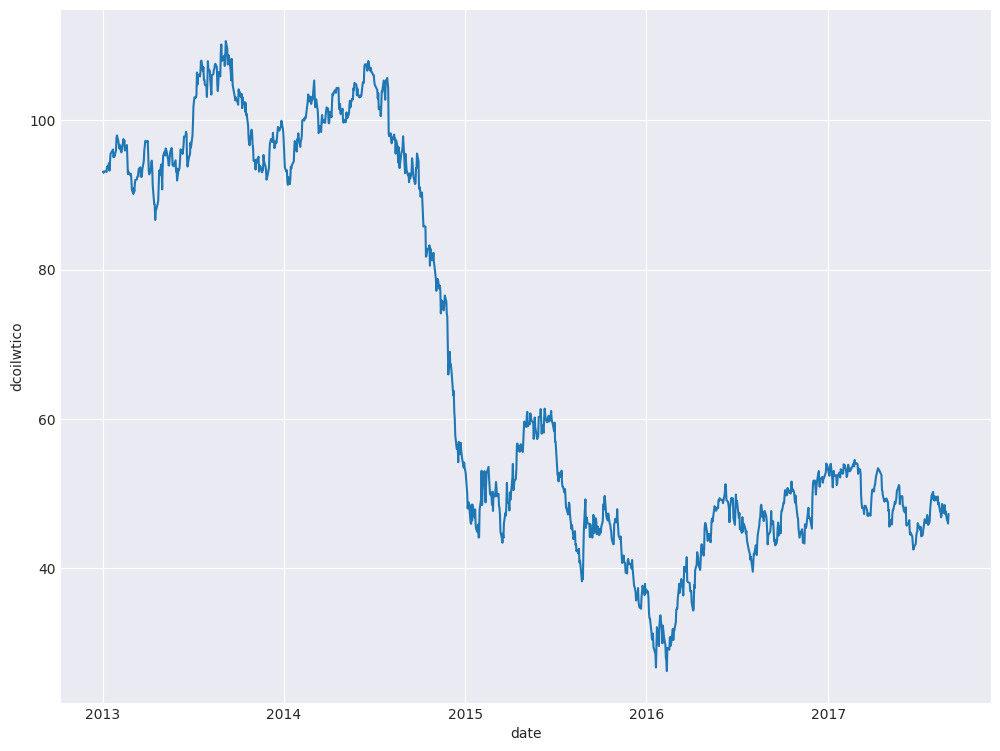

In [ ]:
# Plotting oil price
_ = sns.lineplot(data = oil.dcoilwtico.to_timestamp())

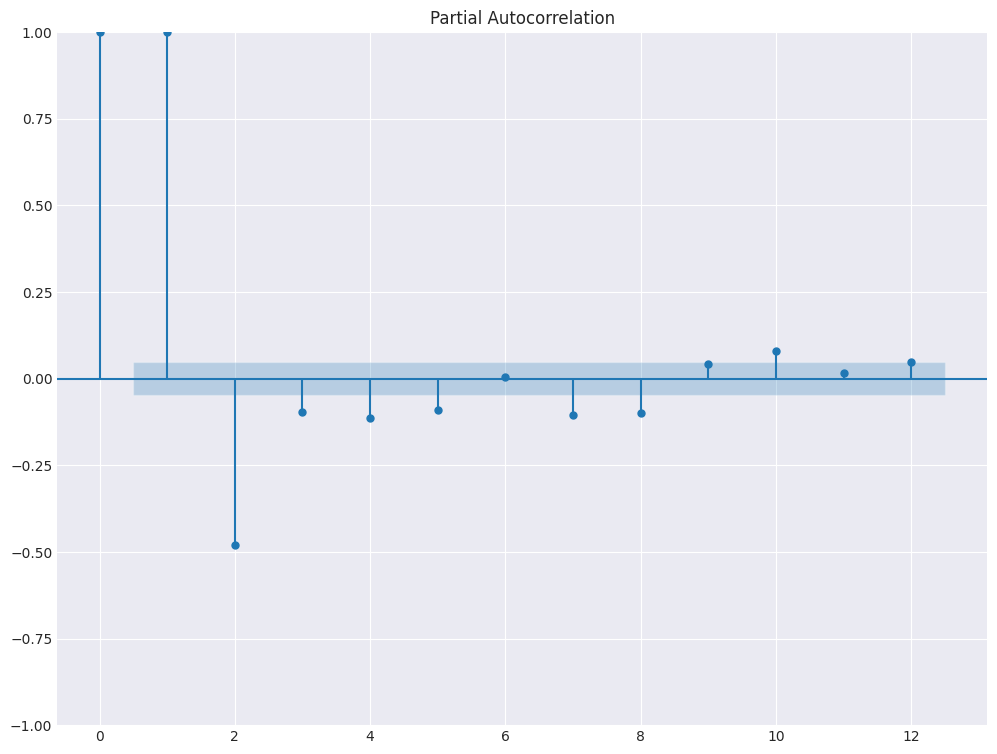

In [ ]:
_ = plot_pacf(calendar.avg_oil, lags = 12) # Lagplot oil price (Feature Engineering)

# Adding lags

In [ ]:
n_lags = 3
for l in range(1, n_lags + 1) :
    calendar[f'oil_lags{l}'] = calendar.avg_oil.shift(l)
calendar.dropna(inplace = True)
calendar

,avg_oil,oil_lags1,oil_lags2,oil_lags3
2013-01-13,93.284286,93.284286,93.284286,93.218571
2013-01-14,93.470000,93.284286,93.284286,93.284286
2013-01-15,93.490000,93.470000,93.284286,93.284286
2013-01-16,93.644286,93.490000,93.470000,93.284286
2013-01-17,93.970000,93.644286,93.490000,93.470000
...,...,...,...,...
2017-08-27,47.720000,47.720000,47.720000,47.598571
2017-08-28,47.624286,47.720000,47.720000,47.720000
2017-08-29,47.320000,47.624286,47.720000,47.720000
2017-08-30,47.115714,47.320000,47.624286,47.720000


# Correlation plot

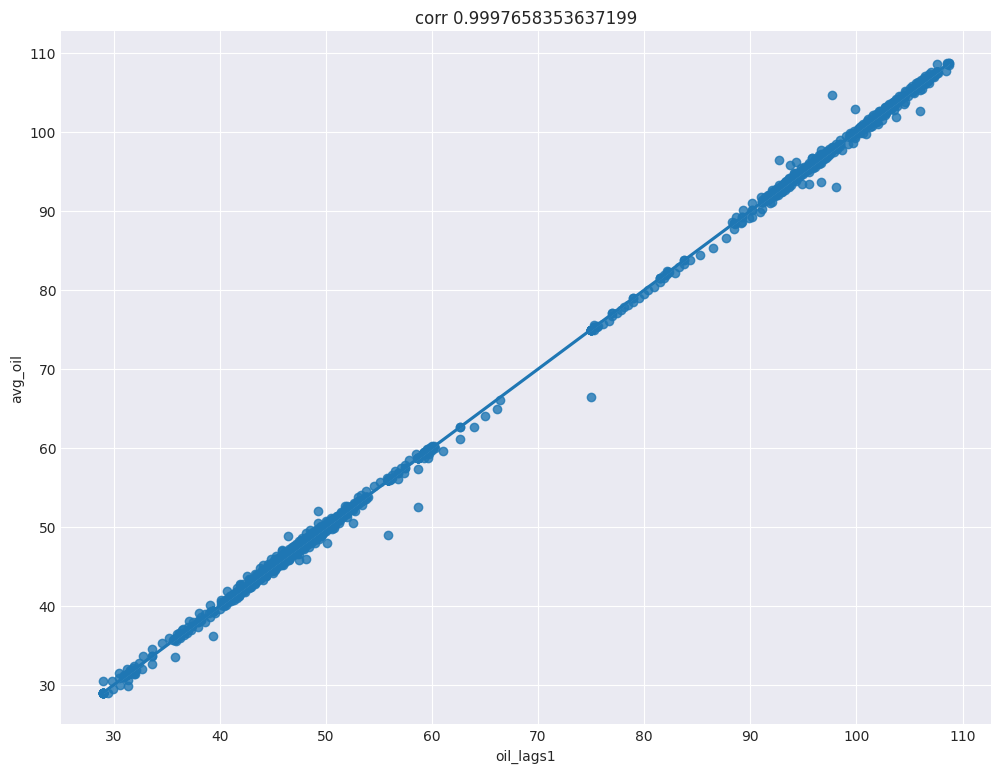

In [ ]:
lag = 'oil_lags1'
plt.figure()
sns.regplot(x = calendar[lag], y = calendar.avg_oil)
plt.title(f'corr {calendar.avg_oil.corr(calendar[lag])}')
plt.show()

# Fetching holiday dataset

In [ ]:
hol = pd.read_csv('/root/holidays_events.csv',
                  parse_dates = ['date'], infer_datetime_format = True,
                  index_col = 'date').to_period('D')
hol = hol[hol.locale == 'National'] # I'm only taking National holiday so there's no false positive.
hol = hol.groupby(hol.index).first() # Removing duplicated holiday at the same date
hol

,type,locale,locale_name,description,transferred
date,,,,,
2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


# Feature Engineering for holiday

In [ ]:
calendar = calendar.join(hol) # Joining calendar with holiday dataset
calendar['dofw'] = calendar.index.dayofweek # Weekly day
calendar['wd'] = 1
calendar.loc[calendar.dofw > 4, 'wd'] = 0 # If it's saturday or sunday then it's not Weekday
calendar.loc[calendar.type == 'Work Day', 'wd'] = 1 # If it's Work Day event then it's a workday
calendar.loc[calendar.type == 'Transfer', 'wd'] = 0 # If it's Transfer event then it's not a work day
calendar.loc[calendar.type == 'Bridge', 'wd'] = 0 # If it's Bridge event then it's not a work day
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = 0 # If it's holiday and the holiday is not transferred then it's holiday
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True), 'wd'] = 1 # If it's holiday and transferred then it's not holiday
calendar = pd.get_dummies(calendar, columns = ['dofw'], drop_first = True) # One-hot encoding (Make sure to drop one of the columns by 'drop_first = True')
calendar = pd.get_dummies(calendar, columns = ['type']) # One-hot encoding for type holiday (No need to drop one of the columns because there's a "No holiday" already)
calendar.drop(['locale', 'locale_name', 'description', 'transferred'], axis = 1, inplace = True) # Unused columns
calendar

,avg_oil,oil_lags1,oil_lags2,oil_lags3,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
2013-01-13,93.284286,93.284286,93.284286,93.218571,0,0,0,0,0,0,1,0,0,0,0,0,0
2013-01-14,93.470000,93.284286,93.284286,93.284286,1,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-15,93.490000,93.470000,93.284286,93.284286,1,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-16,93.644286,93.490000,93.470000,93.284286,1,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-17,93.970000,93.644286,93.490000,93.470000,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,47.720000,47.720000,47.720000,47.598571,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-08-28,47.624286,47.720000,47.720000,47.720000,1,0,0,0,0,0,0,0,0,0,0,0,0
2017-08-29,47.320000,47.624286,47.720000,47.720000,1,1,0,0,0,0,0,0,0,0,0,0,0
2017-08-30,47.115714,47.320000,47.624286,47.720000,1,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
calendar['wd_lag1'] = calendar.wd.shift(1)
calendar['wd_fore1'] = calendar.wd.shift(-1).fillna(0)
calendar.dropna(inplace = True)
calendar

In [ ]:
y = train.unstack(['store_nbr', 'family']).loc['2016-06':'2017']
family = {c[2] for c in train.index}
for f in family :
    ax = y.loc(axis = 1)['sales', :, f].plot(legend = None)
    ax.set_title(f)

In [ ]:
sdate = '2017-04-30' # Start and end of training date
edate = '2017-08-15'

In [ ]:
school_season = [] # Feature for school fluctuations
for i, r in calendar.iterrows() :
    if i.month in [4, 5, 8, 9] :
        school_season.append(1)
    else :
        school_season.append(0)
calendar['school_season'] = school_season
calendar

,avg_oil,oil_lags1,oil_lags2,oil_lags3,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,school_season
2013-01-13,93.284286,93.284286,93.284286,93.218571,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2013-01-14,93.470000,93.284286,93.284286,93.284286,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-15,93.490000,93.470000,93.284286,93.284286,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-16,93.644286,93.490000,93.470000,93.284286,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-17,93.970000,93.644286,93.490000,93.470000,1,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,47.720000,47.720000,47.720000,47.598571,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2017-08-28,47.624286,47.720000,47.720000,47.720000,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2017-08-29,47.320000,47.624286,47.720000,47.720000,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2017-08-30,47.115714,47.320000,47.624286,47.720000,1,0,1,0,0,0,0,0,0,0,0,0,0,1


# DeterministicProcess

In [ ]:
y = train.unstack(['store_nbr', 'family']).loc[sdate:edate]
fourier = CalendarFourier(freq = 'W', order = 4)
dp = DeterministicProcess(index = y.index,
                          order = 1,
                          seasonal = False,
                          constant = False,
                          additional_terms = [fourier],
                          drop = True)
x = dp.in_sample()
x = x.join(calendar)
x

ValueError: ignored

In [ ]:
xtest = dp.out_of_sample(steps = 16) # 16 because we are predicting next 16 days
xtest = xtest.join(calendar)
xtest

In [ ]:
def make_lags(x, lags = 1) : #Fungsi untuk membuat fitur lags
    lags = lags
    x_ = x.copy()
    for i in range(lags) :
        lag = x_.shift(i + 1)
        x = pd.concat([x, lag], axis = 1)
    return x

In [ ]:
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

lnr = LinearRegression(fit_intercept = True, n_jobs = -1, normalize = True)
lnr.fit(x, y)

yfit_lnr = pd.DataFrame(lnr.predict(x), index = x.index, columns = y.columns).clip(0.)
ypred_lnr = pd.DataFrame(lnr.predict(xtest), index = xtest.index, columns = y.columns).clip(0.)

svr = MultiOutputRegressor(SVR(C = 0.2, kernel = 'rbf'), n_jobs = -1)
svr.fit(x, y)

yfit_svr = pd.DataFrame(svr.predict(x), index = x.index, columns = y.columns).clip(0.)
ypred_svr = pd.DataFrame(svr.predict(xtest), index = xtest.index, columns = y.columns).clip(0.)

yfit_mean = pd.DataFrame(np.mean([yfit_svr.values, yfit_lnr.values], axis = 0), index = x.index, columns = y.columns).clip(0.)
ypred_mean = pd.DataFrame(np.mean([ypred_lnr.values, ypred_svr.values], axis = 0), index = xtest.index, columns = y.columns).clip(0.)

y_ = y.stack(['store_nbr', 'family'])
y_['lnr'] = yfit_lnr.stack(['store_nbr', 'family'])['sales']
y_['svr'] = yfit_svr.stack(['store_nbr', 'family'])['sales']
y_['mean'] = yfit_mean.stack(['store_nbr', 'family'])['sales']

print('='*70, 'Linear Regression', '='*70)
print(y_.groupby('family').apply(lambda r : np.sqrt(msle(r['sales'], r['lnr']))))
print('LNR RMSLE :', np.sqrt(msle(y, yfit_lnr)))
print('='*70, 'SVR', '='*70)
print(y_.groupby('family').apply(lambda r : np.sqrt(msle(r['sales'], r['svr']))))
print('SVR RMSLE :', np.sqrt(msle(y, yfit_svr)))
print('='*70, 'Mean', '='*70)
print(y_.groupby('family').apply(lambda r : np.sqrt(msle(r['sales'], r['mean']))))
print('Mean RMSLE :', np.sqrt(msle(y, yfit_mean)))

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

print('='*70, 'Linear Regression', '='*70)
print(y_.groupby('family').apply(lambda r : mae(r['sales'], r['lnr'])))
print('LNR MAE :', mae(y, yfit_lnr))
print('='*70, 'SVR', '='*70)
print(y_.groupby('family').apply(lambda r : mae(r['sales'], r['svr'])))
print('SVR MAE :', mae(y, yfit_svr))
print('='*70, 'Mean', '='*70)
print(y_.groupby('family').apply(lambda r : mae(r['sales'], r['mean'])))
print('Mean MAE :', mae(y, yfit_mean))

In [ ]:
true_low = [2]
pred_low = [4]

print('RMSLE for low value :', np.sqrt(msle(true_low, pred_low)))
print('MAE for low value :', mae(true_low, pred_low))

true_high = [255]
pred_high = [269]

print('RMSLE for high value :', np.sqrt(msle(true_high, pred_high)))
print('MAE for high value :', mae(true_high, pred_high))

In [ ]:
display(x, xtest)

In [ ]:
ypred_svr

In [ ]:
fam = 'BOOKS'
nbr = '1'
plt.rcParams['figure.figsize'] = (15, 9)
plt.figure()
y.loc(axis = 1)['sales', nbr, fam].plot()
yfit_lnr.loc(axis = 1)['sales', nbr, fam].plot(label = 'Linear Regression')
plt.legend()
plt.show()

You can concat linear regression's prediction with the training data, this is called blending.

In [ ]:
ymean = yfit_lnr.append(ypred_lnr)
school = ymean.loc(axis = 1)['sales', :, 'SCHOOL AND OFFICE SUPPLIES']
ymean = ymean.join(school.shift(1), rsuffix = 'lag1') # I'm also adding school lag for it's cyclic yearly.
x = x.loc['2017-05-01':]

In [ ]:
ymean.loc['2017-08-16':]

In [ ]:
x = x.join(ymean) # Concating linear result
xtest = xtest.join(ymean)
display(x, xtest)

In [ ]:
y = y.loc['2017-05-01':]
y

In [ ]:
print(y.isna().sum().sum())
display(x, xtest)

# Model Creation

In [ ]:
from joblib import Parallel, delayed
import warnings

# Import necessary library
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor

# SEED for reproducible result
SEED = 5

class CustomRegressor():
    
    def __init__(self, n_jobs=-1, verbose=0):
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        self.estimators_ = None
        
    def _estimator_(self, X, y):
    
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES': # Because SCHOOL AND OFFICE SUPPLIES has weird trend, we use decision tree instead.
            r1 = ExtraTreesRegressor(n_estimators = 225, n_jobs=-1, random_state=SEED)
            r2 = RandomForestRegressor(n_estimators = 225, n_jobs=-1, random_state=SEED)
            b1 = BaggingRegressor(base_estimator=r1,
                                  n_estimators=10,
                                  n_jobs=-1,
                                  random_state=SEED)
            b2 = BaggingRegressor(base_estimator=r2,
                                  n_estimators=10,
                                  n_jobs=-1,
                                  random_state=SEED)
            model = VotingRegressor([('et', b1), ('rf', b2)]) # Averaging the result
        else:
            ridge = Ridge(fit_intercept=True, solver='auto', alpha=0.75, normalize=True, random_state=SEED)
            svr = SVR(C = 0.2, kernel = 'rbf')
            
            model = VotingRegressor([('ridge', ridge), ('svr', svr)]) # Averaging result
        model.fit(X, y)

        return model

    def fit(self, X, y):
        from tqdm.auto import tqdm
        
        
        if self.verbose == 0 :
            self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                                  verbose=0,
                                  )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in range(y.shape[1]))
        else :
            print('Fit Progress')
            self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                                  verbose=0,
                                  )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in tqdm(range(y.shape[1])))
        return
    
    def predict(self, X):
        from tqdm.auto import tqdm
        if self.verbose == 0 :
            y_pred = Parallel(n_jobs=self.n_jobs, 
                              verbose=0)(delayed(e.predict)(X) for e in self.estimators_)
        else :
            print('Predict Progress')
            y_pred = Parallel(n_jobs=self.n_jobs, 
                              verbose=0)(delayed(e.predict)(X) for e in tqdm(self.estimators_))
        
        return np.stack(y_pred, axis=1)

In [ ]:
%%time

model = CustomRegressor(n_jobs=-1, verbose=1)
model.fit(x, y)
y_pred = pd.DataFrame(model.predict(x), index=x.index, columns=y.columns)

In [ ]:
display(y_pred)
print(y_pred.isna().sum().sum())

# Evaluation

In [ ]:
from sklearn.metrics import mean_squared_log_error
y_pred = y_pred.stack(['store_nbr', 'family']).clip(0.)
y_ = y.stack(['store_nbr', 'family']).clip(0.)

y_['pred'] = y_pred.values
print(y_.groupby('family').apply(lambda r : np.sqrt(np.sqrt(mean_squared_log_error(r['sales'], r['pred'])))))
# Looking at error
print('RMSLE : ', np.sqrt(np.sqrt(msle(y_['sales'], y_['pred']))))

In [ ]:
y_pred.isna().sum()

In [ ]:
ypred = pd.DataFrame(model.predict(xtest), index = xtest.index, columns = y.columns).clip(0.)
ypred

In [ ]:
ypred = ypred.stack(['store_nbr', 'family'])
ypred

# Submission

In [ ]:
sub = pd.read_csv('/root/sample_submission.csv')
sub['sales'] = ypred.values
sub.to_csv('submission.csv', index = False) # Submit
sub